# pre

Referencing https://blog.csdn.net/LoseInVain/article/details/88139435

# native implementation

In [69]:
import torch
inp = torch.randn(1, 3, 4, 5).cuda()
w = torch.ones(2, 3, 3, 3).cuda() / 3.14 # input channel is 3, output channel is 2
print('Input shape:', inp.shape, 'kernel shape:', w.shape)

inp_unf = torch.nn.functional.unfold(inp, (3, 3)) # torch.Size([1, 27, 6])
print('Input unfolded: ', inp_unf.shape)
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
print('Conved: ', out_unf.shape)
out = torch.nn.functional.fold(out_unf, (2, 3), (1, 1))
# or equivalently (and avoiding a copy),
# out = out_unf.view(1, 2, 7, 8)

torch_out = torch.nn.functional.conv2d(inp, w)

diff = (torch_out - out).abs().max()
print('Out shape:', out.shape, diff)

Input shape: torch.Size([1, 3, 4, 5]) kernel shape: torch.Size([2, 3, 3, 3])
Input unfolded:  torch.Size([1, 27, 6])
Conved:  torch.Size([1, 2, 6])
Out shape: torch.Size([1, 2, 2, 3]) tensor(7.1526e-07, device='cuda:0')


# from torch

In [70]:
conv_op = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=[3, 3]).cuda()
conv_op.weight.data.fill_(1./3.14)
conv_op.bias.data.fill_(0.0)
torch_conv_out = conv_op(inp.cuda())
print(torch_conv_out.shape, (torch_conv_out - out).abs().max())

torch.Size([1, 2, 2, 3]) tensor(7.7486e-07, device='cuda:0', grad_fn=<MaxBackward1>)


# from pac-conv

In [71]:
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/third-parties/pacnet/')
import pac_simplified as pac
pac_conv_op = pac.PacConv2d(in_channels=3, out_channels=2, kernel_size=[3, 3]).cuda()
pac_conv_op.weight.data.fill_(1./3.14)
pac_conv_op.bias.data.fill_(0.0)
pac_conv_out, kernel_list = pac_conv_op(inp, torch.ones_like(inp))
print(pac_conv_out.shape, (pac_conv_out - out).abs().max())

torch.Size([1, 2, 2, 3]) tensor(4.7684e-07, device='cuda:0', grad_fn=<MaxBackward1>)


# from DCN

In [102]:
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/modules')
from modules.deform_conv import DeformConv
import torch.nn as nn


N, inC, inH, inW = inp.shape 
deformable_groups = 1
outC = 2
kH, kW = 3, 3

DCN_conv_op = DeformConv(in_channels=3, out_channels=2, kernel_size=[3, 3], stride=1, padding=0, dilation=1,
                   groups=1, 
                   deformable_groups=1, im2col_step=1).cuda()
DCN_conv_op.weight.data.fill_(1./3.14)
DCN_conv_op.bias.data.fill_(1.0)
conv_op = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=[3, 3]).cuda()
# DCN_conv_op.weight = conv_op.weight
# DCN_conv_op.bias = conv_op.bias

conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=(1, 1),
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(inp)
print('Offsets:', offsets.shape, inp.shape)

DCN_conv_out = DCN_conv_op(inp, offsets)
print(DCN_conv_out.shape, (DCN_conv_out - out).abs().max())

Offsets: torch.Size([1, 18, 4, 5]) torch.Size([1, 3, 4, 5])
torch.Size([1, 2, 2, 3]) tensor(2.5099, device='cuda:0', grad_fn=<MaxBackward1>)


# from DCN-func

In [1]:
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/')
from modules.deform_conv import DeformConv
import torch.nn as nn
import torch

inp = torch.randn(1, 3, 4, 5).cuda()
w = torch.ones(2, 3, 3, 3).cuda() / 3.14 # input channel is 3, output channel is 2
# print('Input shape:', inp.shape, 'kernel shape:', w.shape)

# Native conv
conv_op = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=[3, 3]).cuda()
conv_op.weight.data.fill_(1./3.14)
conv_op.bias.data.fill_(1.0)
torch_conv_out = conv_op(inp.cuda())

# deform-conv params

N, inC, inH, inW = inp.shape 
deformable_groups = 1
inC = 3
outC = 2
kH, kW = 3, 3
kernel_size=(kH, kW)
stride = (1, 1)
padding = (0, 0)
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

from functions.deform_conv_func import DeformConvFunction

# Offsets
conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=(1, 1),
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(inp)

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1./3.14)
bias.data.fill_(1.0)

DCN_func_output = DeformConvFunction.apply(inp, offsets, 
                          weight, 
                          bias, 
                          stride, 
                          padding, 
                          dilation, 
                          groups,
                          deformable_groups,
                          im2col_step)
print(DCN_func_output.shape, torch_conv_out.shape)
print((DCN_func_output - torch_conv_out).abs().max())

torch.Size([1, 2, 2, 3]) torch.Size([1, 2, 2, 3])
tensor(2.3842e-07, device='cuda:0', grad_fn=<MaxBackward1>)


# from customized DCN-unfold

In [2]:
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/modules')
from modules.deform_conv import DeformConv
import torch.nn as nn
import torch

inp = torch.randn(1, 3, 4, 5).cuda()
w = torch.ones(2, 3, 3, 3).cuda() / 3.14 # input channel is 3, output channel is 2
print('Input shape:', inp.shape, 'kernel shape:', w.shape)

# native unfold
inp_unf = torch.nn.functional.unfold(inp, (3, 3)) # torch.Size([1, 27, 6]); 
# [1, 3, 4, 5] -> [1, 27(kH*kW*inC), 6(locatations)]
print('Input unfolded: ', inp_unf.shape)

print(inp_unf.grad_fn) # None; this is saying the deform-unfold only needs to compute grad of the output / offset

Input shape: torch.Size([1, 3, 4, 5]) kernel shape: torch.Size([2, 3, 3, 3])
Input unfolded:  torch.Size([1, 27, 6])
None


In [5]:
# deform-conv params

N, inC, inH, inW = inp.shape 
deformable_groups = 1
inC = 3
outC = 2
kH, kW = 3, 3
kernel_size=(kH, kW)
stride = (1, 1)
padding = (0, 0)
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

# Offsets
conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=(1, 1),
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(inp)

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1./3.14)
bias.data.fill_(1.0)
kernel_size = weight.shape[2:4]

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction

DCN_im2col_func_output = DeformIm2colFunction.apply(inp, offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation, 
                                                    groups,
                                                    deformable_groups,
                                                    im2col_step)
print(DCN_im2col_func_output.shape, inp_unf.shape)
print((DCN_im2col_func_output - inp_unf).abs().max())

torch.Size([1, 27, 6]) torch.Size([1, 27, 6])
tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)


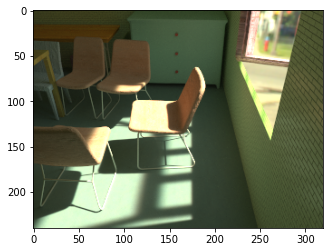

Input unfolded:  torch.Size([1, 147, 76800])
Conved:  torch.Size([1, 3, 76800])
Out:  torch.Size([1, 3, 240, 320])
Offsets: torch.Size([1, 98, 240, 320])


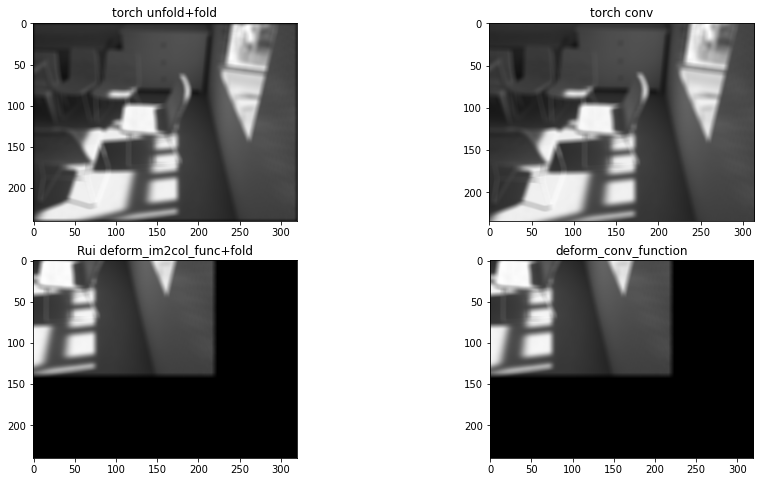

In [37]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
plt.imshow(im_uint8)
plt.show()
im_float = im_uint8.astype(np.float32)
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()

w = torch.ones(3, 3, 7, 7).cuda() # input channel is 3, output channel is 3
inp_unf = torch.nn.functional.unfold(im_tensor, (7, 7), padding=3) # torch.Size([1, 27, 6])
print('Input unfolded: ', inp_unf.shape)
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
print('Conved: ', out_unf.shape)
out = torch.nn.functional.fold(out_unf, (240, 320), (1, 1))
print('Out: ', out.shape)

plt.figure(figsize=(15, 8))
# plt.title('[0] torch unfold+fold, [1] torch conv [2] Rui deform_im2col_func+fold')
ax = plt.subplot(221)
ax.title.set_text('torch unfold+fold')
out_float = out.cpu().squeeze().permute(1, 2, 0).numpy()
out_float = out_float / np.max(out_float)
plt.imshow(out_float)

ax = plt.subplot(222)
ax.title.set_text('torch conv')
torch_out = torch.nn.functional.conv2d(im_tensor, w)
torch_out_float = torch_out.cpu().squeeze().permute(1, 2, 0).numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)

ax = plt.subplot(223)
ax.title.set_text('Rui deform_im2col_func+fold')
N, inC, inH, inW = im_tensor.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

offsets = torch.zeros_like(offsets, device=offsets.device, requires_grad=True)+100

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction, DeformConvFunction

DCN_im2col_func_output = DeformIm2colFunction.apply(im_tensor.contiguous(), offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation)
print(DCN_im2col_func_output.grad_fn)
torch_out_unf = DCN_im2col_func_output.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(torch_out_unf, (240, 320), (1, 1))
torch_out_float = torch_out.cpu().squeeze().permute(1, 2, 0).detach().numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)

ax = plt.subplot(224)
ax.title.set_text('deform_conv_function')
DCN_func_output = DeformConvFunction.apply(im_tensor.contiguous(), offsets, 
                          weight, 
                          bias, 
                          stride, 
                          padding, 
                          dilation, 
                          groups,
                          deformable_groups,
                          im2col_step)
print(DCN_func_output.grad_fn)
torch_out_float = DCN_func_output.cpu().squeeze().permute(1, 2, 0).detach().numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)
plt.show()

### Test grad

In [28]:
import imageio, torch
import numpy as np
import torch.nn as nn

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32)
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()
zeros = im_tensor * 0.
zeros.requires_grad = True
im_tensor = im_tensor + zeros

N, inC, inH, inW = im_tensor.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

conv_offset_op = torch.nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction, DeformConvFunction
DCN_func_output = DeformConvFunction.apply(im_tensor.contiguous(), offsets, 
                          weight, 
                          bias, 
                          stride, 
                          padding, 
                          dilation, 
                          groups,
                          deformable_groups,
                          im2col_step)
print(DCN_func_output.grad_fn)
loss = torch.sum(DCN_func_output)
loss.backward()
# print(im_tensor.grad)
print('grad on offsets:', offsets.grad, offsets.requires_grad)
print('grad on conv_offset_op.weight:', conv_offset_op.weight.grad.shape, conv_offset_op.weight.requires_grad)
print('grad on zeros:', zeros.grad.shape, zeros.requires_grad)

Offsets: torch.Size([1, 98, 240, 320])
grad on offsets: None True
grad on conv_offset_op.weight: torch.Size([98, 3, 7, 7]) True
grad on zeros: torch.Size([1, 3, 240, 320]) True


/home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


In [32]:
print(conv_offset_op.weight.grad[:5, :2, 0, 0])
print(zeros.grad[0, :3, :3, :2])

tensor([[-11999823., -14023026.],
        [-18190084., -20485984.],
        [-12557574., -14059662.],
        [ -9550245., -10461480.],
        [ -8378754.,  -9190419.]], device='cuda:0')
tensor([[[48., 60.],
         [60., 75.],
         [72., 90.]],

        [[48., 60.],
         [60., 75.],
         [72., 90.]],

        [[48., 60.],
         [60., 75.],
         [72., 90.]]], device='cuda:0')


In [33]:
import imageio, torch
import numpy as np
import torch.nn as nn

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32)
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()
zeros = im_tensor * 0.
zeros.requires_grad = True
im_tensor = im_tensor + zeros

N, inC, inH, inW = im_tensor.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

conv_offset_op = torch.nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

DCN_im2col_func_output = DeformIm2colFunction.apply(im_tensor.contiguous(), offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation)
print(DCN_im2col_func_output.grad_fn)
torch_out_unf = DCN_im2col_func_output.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(torch_out_unf, (240, 320), (1, 1))
loss = torch.sum(torch_out)

loss.backward()
# print(im_tensor.grad)
print('grad on offsets:', offsets.grad, offsets.requires_grad)
print('grad on conv_offset_op.weight:', conv_offset_op.weight.grad.shape, conv_offset_op.weight.requires_grad)
print('grad on zeros:', zeros.grad.shape, zeros.requires_grad)

Offsets: torch.Size([1, 98, 240, 320])
grad on offsets: None True
grad on conv_offset_op.weight: torch.Size([98, 3, 7, 7]) True
grad on zeros: torch.Size([1, 3, 240, 320]) True


/home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


In [34]:
print(conv_offset_op.weight.grad[:5, :2, 0, 0])
print(zeros.grad[0, :3, :3, :2])

tensor([[-11999823., -14023026.],
        [-18190084., -20485984.],
        [-12557574., -14059662.],
        [ -9550245., -10461480.],
        [ -8378754.,  -9190419.]], device='cuda:0')
tensor([[[48., 60.],
         [60., 75.],
         [72., 90.]],

        [[48., 60.],
         [60., 75.],
         [72., 90.]],

        [[48., 60.],
         [60., 75.],
         [72., 90.]]], device='cuda:0')


### check im2col module

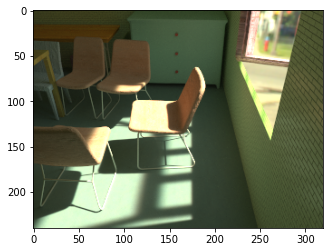

Input unfolded:  torch.Size([1, 147, 76800])
Conved:  torch.Size([1, 3, 76800])
Out:  torch.Size([1, 3, 240, 320])
Offsets: torch.Size([1, 98, 240, 320])


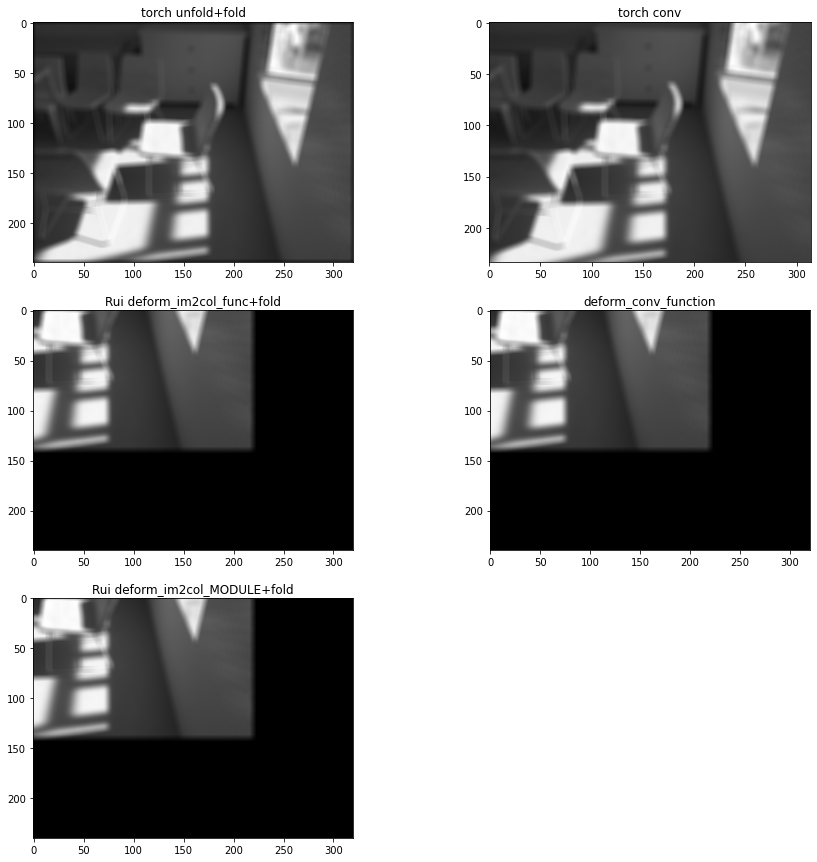

In [3]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/modules')

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
plt.imshow(im_uint8)
plt.show()
im_float = im_uint8.astype(np.float32)
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()

w = torch.ones(3, 3, 7, 7).cuda() # input channel is 3, output channel is 3
inp_unf = torch.nn.functional.unfold(im_tensor, (7, 7), padding=3) # torch.Size([1, 27, 6])
print('Input unfolded: ', inp_unf.shape)
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
print('Conved: ', out_unf.shape)
out = torch.nn.functional.fold(out_unf, (240, 320), (1, 1))
print('Out: ', out.shape)

plt.figure(figsize=(15, 15))
# plt.title('[0] torch unfold+fold, [1] torch conv [2] Rui deform_im2col_func+fold')
ax = plt.subplot(321)
ax.title.set_text('torch unfold+fold')
out_float = out.cpu().squeeze().permute(1, 2, 0).numpy()
out_float = out_float / np.max(out_float)
plt.imshow(out_float)

ax = plt.subplot(322)
ax.title.set_text('torch conv')
torch_out = torch.nn.functional.conv2d(im_tensor, w)
torch_out_float = torch_out.cpu().squeeze().permute(1, 2, 0).numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)

ax = plt.subplot(323)
ax.title.set_text('Rui deform_im2col_func+fold')
N, inC, inH, inW = im_tensor.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

offsets = torch.zeros_like(offsets, device=offsets.device, requires_grad=True)+100

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction, DeformConvFunction

DCN_im2col_func_output = DeformIm2colFunction.apply(im_tensor.contiguous(), offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation)
print(DCN_im2col_func_output.grad_fn)
torch_out_unf = DCN_im2col_func_output.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(torch_out_unf, (240, 320), (1, 1))
torch_out_float = torch_out.cpu().squeeze().permute(1, 2, 0).detach().numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)

ax = plt.subplot(324)
ax.title.set_text('deform_conv_function')
DCN_func_output = DeformConvFunction.apply(im_tensor.contiguous(), offsets, 
                          weight, 
                          bias, 
                          stride, 
                          padding, 
                          dilation, 
                          groups,
                          deformable_groups,
                          im2col_step)
print(DCN_func_output.grad_fn)
torch_out_float = DCN_func_output.cpu().squeeze().permute(1, 2, 0).detach().numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)

ax = plt.subplot(325)
ax.title.set_text('Rui deform_im2col_MODULE+fold')
from deform_conv import DeformIm2col
DCN_im2col_op = DeformIm2col(
    in_channels=3, out_channels=3, kernel_size=[7, 7], stride=1, padding=3, dilation=1,
    groups=1, 
    deformable_groups=1, im2col_step=1).cuda()

DCN_im2col_op_output = DCN_im2col_op(im_tensor.contiguous(), offsets)
print(DCN_im2col_func_output.grad_fn)
torch_out_unf = DCN_im2col_op_output.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(torch_out_unf, (240, 320), (1, 1))
torch_out_float = torch_out.cpu().squeeze().permute(1, 2, 0).detach().numpy()
torch_out_float = torch_out_float / np.max(torch_out_float)
plt.imshow(torch_out_float)



plt.show()

# Final check grad

In [1]:
import imageio, torch
import numpy as np
import torch.nn as nn

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32)
im_tensor_ori = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()

N, inC, inH, inW = im_tensor_ori.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

In [13]:
im_tensor_op = nn.Conv2d(3, 3,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1), 
                        bias=True).cuda()

im_tensor_op.weight.data.fill_(1.0)
im_tensor_op.bias.data.fill_(0.0)
im_tensor = im_tensor_op(im_tensor_ori)

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

conv_offset_op = torch.nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.00)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

DCN_im2col_func_output = DeformIm2colFunction.apply(im_tensor.contiguous(), offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation)
print(DCN_im2col_func_output.grad_fn)
loss = torch.sum(DCN_im2col_func_output)

torch_out_unf = DCN_im2col_func_output.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(torch_out_unf, (240, 320), (1, 1))
loss = torch.sum(torch_out)

loss.backward()
# print(im_tensor.grad)
# print('grad on offsets:', offsets.grad, offsets.requires_grad)
print('grad on conv_offset_op.weight:', conv_offset_op.weight.grad.shape, conv_offset_op.weight.grad[:2, :3, 1, 0], conv_offset_op.weight.requires_grad)
print('grad on im_tensor_op.weight:', im_tensor_op.weight.grad.shape, im_tensor_op.weight.grad[:, :, :3, 0], im_tensor_op.weight.requires_grad)
# for x in [conv_offset_op.weight.grad, conv_offset_op.bias.grad, im_tensor_op.weight.grad, im_tensor_op.bias.grad, weight.grad, bias.grad]:
#     x.data = None

Offsets: torch.Size([1, 98, 240, 320])
grad on conv_offset_op.weight: torch.Size([98, 3, 7, 7]) tensor([[ 3.0005e+10,  3.0005e+10,  3.0005e+10],
        [-1.0745e+10, -1.0745e+10, -1.0745e+10]], device='cuda:0') True
grad on im_tensor_op.weight: torch.Size([3, 3, 3, 3]) tensor([[[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]],

        [[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]],

        [[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]]], device='cuda:0') True


In [14]:
im_tensor_op = nn.Conv2d(3, 3,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1), 
                        bias=True).cuda()

im_tensor_op.weight.data.fill_(1.0)
im_tensor_op.bias.data.fill_(0.0)
im_tensor = im_tensor_op(im_tensor_ori)

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

inp_unf = torch.nn.functional.unfold(im_tensor, kernel_size, stride=stride, padding=padding, dilation=dilation) # torch.Size([1, 27, 6])
out_unf = inp_unf.transpose(1, 2).matmul(weight.view(weight.size(0), -1).t()).transpose(1, 2)
torch_out = torch.nn.functional.fold(out_unf, (240, 320), (1, 1))
loss = torch.sum(torch_out)
loss.backward()

print('grad on im_tensor:', im_tensor_op.weight.grad.shape, im_tensor_op.weight.grad[:, :, :3, 0], im_tensor_op.weight.requires_grad)

grad on im_tensor: torch.Size([3, 3, 3, 3]) tensor([[[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]],

        [[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]],

        [[1.0648e+09, 1.0674e+09, 1.0654e+09],
         [1.1440e+09, 1.1473e+09, 1.1455e+09],
         [8.2585e+08, 8.2857e+08, 8.2777e+08]]], device='cuda:0') True


# extra

In [1]:
import imageio, torch
import numpy as np
import torch.nn as nn

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
from deform_conv_func import DeformIm2colFunction

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32)
im_tensor_ori = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()

N, inC, inH, inW = im_tensor_ori.shape 
deformable_groups = 1
inC = 3
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 3
dilation=1
groups=1
deformable_groups=1
im2col_step=1
bias=True

im_tensor_op = nn.Conv2d(3, 3,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1), 
                        bias=True).cuda()

im_tensor_op.weight.data.fill_(1.0)
im_tensor_op.bias.data.fill_(0.0)
im_tensor = im_tensor_op(im_tensor_ori)
# im_tensor = torch.zeros_like(im_tensor, requires_grad=True, device=im_tensor.device).cuda()

# deform-conv itself
weight = nn.Parameter(torch.Tensor(
    outC, inC//groups, *kernel_size)).cuda()
bias = nn.Parameter(torch.Tensor(outC)).cuda()
weight.data.fill_(1.)
bias.data.fill_(0.0)

conv_offset_op = torch.nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        bias=True).cuda()
conv_offset_op.weight.data.fill_(0.00)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
print('Offsets:', offsets.shape)

# inp_unf = torch.nn.functional.unfold(im_tensor, kernel_size, stride=stride, padding=padding, dilation=dilation) # torch.Size([1, 27, 6])
inp_unf = DeformIm2colFunction.apply(im_tensor, offsets, 
                                                    kernel_size, 
                                                    stride, 
                                                    padding, 
                                                    dilation)
loss = torch.sum(inp_unf) - 2
loss.backward()

# print(im_tensor_op.weight.grad)
print(conv_offset_op.weight.grad)
# print('grad on im_tensor:', im_tensor_op.weight.grad.shape, im_tensor_op.weight.grad[:, :, :3, 0], im_tensor_op.weight.requires_grad)

# for x in [conv_offset_op.weight.grad, conv_offset_op.bias.grad, im_tensor_op.weight.grad, im_tensor_op.bias.grad]:
#     x.data.zero_()

Offsets: torch.Size([1, 98, 240, 320])
=== torch.Size([1, 147, 76800]) tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED
Exception raised from createCuDNNHandle at /pytorch/aten/src/ATen/cudnn/Handle.cpp:9 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7f6a5319d1e2 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xfef088 (0x7f6a545f5088 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #2: at::native::getCudnnHandle() + 0x108d (0x7f6a545f696d in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #3: <unknown function> + 0xebcaec (0x7f6a544c2aec in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xeb800e (0x7f6a544be00e in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xeb9bfb (0x7f6a544bfbfb in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: at::native::cudnn_convolution_backward_input(c10::ArrayRef<long>, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool) + 0xb2 (0x7f6a544c0152 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0xf1f35b (0x7f6a5452535b in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #8: <unknown function> + 0xf4f178 (0x7f6a54555178 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: at::cudnn_convolution_backward_input(c10::ArrayRef<long>, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool) + 0x1ad (0x7f6a8f3fd88d in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::native::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x223 (0x7f6a544be823 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #11: <unknown function> + 0xf1f445 (0x7f6a54525445 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #12: <unknown function> + 0xf4f1d4 (0x7f6a545551d4 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #13: at::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x1e2 (0x7f6a8f40c242 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x2ec9c62 (0x7f6a910cfc62 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2ede224 (0x7f6a910e4224 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: at::cudnn_convolution_backward(at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, long, bool, bool, std::array<bool, 2ul>) + 0x1e2 (0x7f6a8f40c242 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::generated::CudnnConvolutionBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x258 (0x7f6a90f56c38 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #18: <unknown function> + 0x3375bb7 (0x7f6a9157bbb7 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #19: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f6a91577400 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #20: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f6a91577fa1 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #21: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f6a91570119 in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f6a9ed10dea in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #23: <unknown function> + 0xc819d (0x7f6b0e83119d in /home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #24: <unknown function> + 0x76db (0x7f6b116736db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #25: clone + 0x3f (0x7f6b1139ca3f in /lib/x86_64-linux-gnu/libc.so.6)
